## Numerical integration of Ordinary Differential Equations
This notebook serves as a quick refresher on ordinary differntial equations. If you are familiar with the topic: feel free to skim this notebook.

We will first consider the decay of tritium as an example:

$$
\mathrm{^3H \overset{\lambda}\rightarrow\ ^3He + e^- + \bar{\nu_e}}
$$

We will not concern ourselves with the products, instead we will only take interest in the number density of $\mathrm{^3H}$ as function of time, let's call it $y(t)$. The rate of change of $y(t)$ is proportional to itself and the decay constant ($\lambda$):

$$
\frac{dy(t)}{dt} = -\lambda y(t)
$$

you probably know the solution to this class of differential equations (either from experience or by guessing an appropriate ansatz). SymPy can of course also solve this equation:

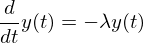

In [1]:
import sympy as sym
sym.init_printing()
t, l = sym.symbols('t lambda')
y = sym.Function('y')(t)
dydt = y.diff(t)
expr = sym.Eq(dydt, -l*y)
expr

In [2]:
sym.dsolve(expr)

Now, pretend for a while that this function lacked an analytic solution. We could then integrate this equation *numerically* from an initial state for a predetermined amount of time by discretizing the time into a seriers of small steps. And for each of these steps we would update $y$ by multiplying the derivative with the step size (assuming that the derivate is approximately constant on the scale of the step-size), formally this method is known as "forward Euler":

$$
y_{n+1} = y_n + y'(t_n)\cdot \Delta h
$$

it is quite easy to implement in Python, e.g.:

In [3]:
import numpy as np
def euler_fw(rhs, y0, tout, params):
    y0 = np.atleast_1d(np.asarray(y0, dtype=np.float64))
    dydt = np.empty_like(y0)
    yout = np.zeros((len(tout), len(y0)))
    yout[0] = y0
    t_old = tout[0]
    for i, t in enumerate(tout[1:], 1):
        dydt[:] = rhs(yout[i-1], t, *params)
        h = t - t_old
        yout[i] = yout[i-1] + dydt*h
        t_old = t
    return yout

applying this function on our model problem:

In [4]:
tout = np.linspace(0, 1, 100)
params = (2,)
yout = euler_fw(lambda y, t, l: -l*y, 3, tout, params)

and plotting the solution & the numerical error using matplotlib:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def my_plot(tout, yout, params, xlbl='time / a.u.', ylabel=None, analytic=None):
    fig, axes = plt.subplots(1, 2 if analytic else 1, figsize=(14, 4))
    axes = np.atleast_1d(axes)
    for i in range(yout.shape[1]):
        axes[0].plot(tout, yout[:, i], label='y%d' % i)
    if ylabel:
        axes[0].set_ylabel(ylabel)
    for ax in axes:
        ax.set_xlabel(xlbl)
    if analytic:
        axes[0].plot(tout, analytic(tout, yout, params), '--')
        axes[1].plot(tout, yout[:, 0] - 3*np.exp(-2*(tout-tout[0])))
        if ylabel:
            axes[1].set_ylabel('Error in ' + ylabel)


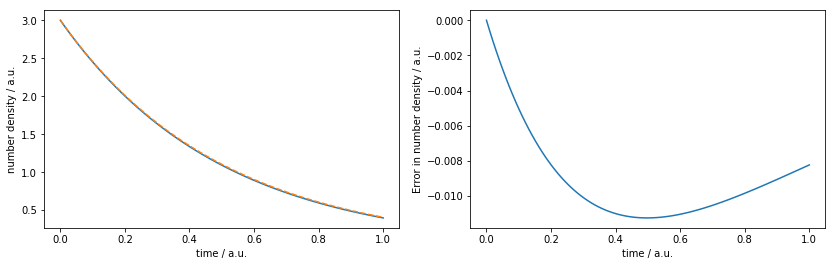

In [6]:
def analytic(tout, yout, params):
    return yout[0, 0]*np.exp(-params[0]*tout)
my_plot(tout, yout, params, analytic=analytic, ylabel='number density / a.u.')

Well, that was easy: 100 points gave us almost plotting accuracy. Unfortunately, Euler forward is not practical for most real world problems. Usually we want a higher order formula (the error in euler forward scales only as $n^{-1}$), and we want to use an adaptive step size (larger steps when the function is smooth). Furthermore, for a large class of problems, we need to base the step not on the derivative at the current time point, but rather at the next time point (giving rise to an implicit expression). We will not go into the details of this at all. Instead we will use the well tested LSODA algorithm (provided in scipy as ``odeint``):

Number of function evaluations: 75


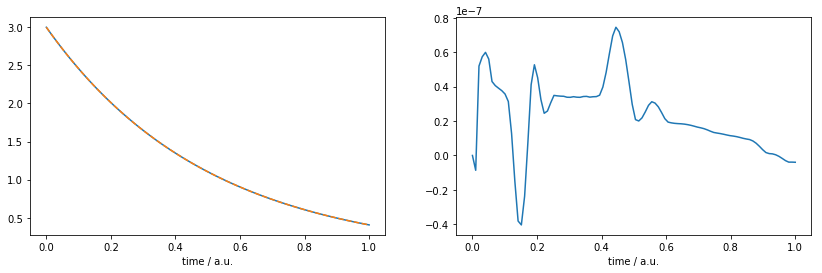

In [7]:
from scipy.integrate import odeint
yout, info = odeint(lambda y, t, l: -l*y, 3, tout, params, full_output=True)
my_plot(tout, yout, params, analytic=analytic)
print("Number of function evaluations: %d" % info['nfe'][-1])

We can see that ``odeint`` was able to achieve a much higher precision using fewer number of function evaluations.

Furthermore, the LSODA algortihm switches to an implicit stepper if the problem becomes "stiff". The simplest implicit stepper is "backward euler" (though not what is used by LSODA):

$$
y_{n+1} = y_n + y'(t_{n+1})\cdot \Delta h
$$

In the upcoming notebooks we will use ``odeint`` to solve systems of ODEs (and not only linear equations as in this notebook). The emphasis is not on the numerical methods, but rather on how we, from symbolic expressions, can generate fast functions for the solver.

But in order to show how we would formulate a system of differential equations we will here briefly look at the [van der Pol osciallator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator). It is a second order differential equation:

$$
{d^2y_0 \over dx^2}-\mu(1-y_0^2){dy_0 \over dx}+y_0= 0
$$

One way to reduce the order of our second order differential equation is to formulate a system of first order ODEs, using:

$$ y_1 = \dot y_0 $$

which gives us:

$$
\begin{cases}
\dot y_0 = y_1 \\
\dot y_1 = \mu(1-y_0^2) y_1-y_0
\end{cases}
$$

Let's call the function for this system of ordinary differential equations ``vdp``:

In [8]:
def vdp(y, t, mu):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0]
    ]

using "Euler forward":

In [9]:
tout = np.linspace(0, 200, 1024)
y_init, params = [1, 0], (17,)
y_euler = euler_fw(vdp, y_init, tout, params)

/home/moorepants/miniconda3/envs/codegen17/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/moorepants/miniconda3/envs/codegen17/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()


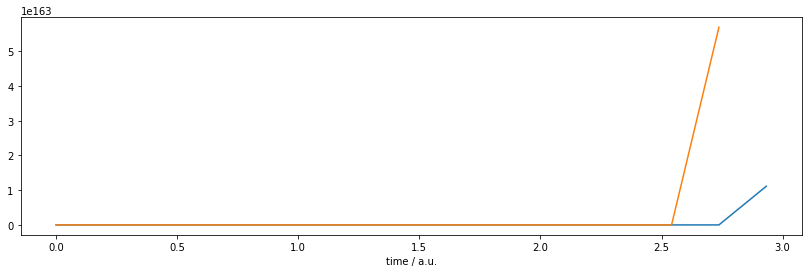

In [10]:
my_plot(tout, y_euler, params)

That does not look like an oscillator. (we see that Euler forward has deviated to values with enormous magnitude), here the advanced treament by the ``odeint`` solver is far superior:

Number of function evaluations: 9244, number of Jacobian evaluations: 211


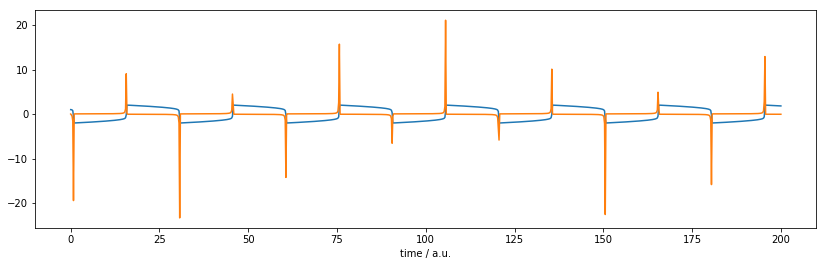

In [11]:
y_odeint, info = odeint(vdp, y_init, tout, params, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))
my_plot(tout, y_odeint, params)

We see that LSODA has evaluated the Jacobian. But we never gave it an explicit representation of it―so how could it?

It estimated the Jacobian matrix by using finite differences. Let's see if it can do better if we provide a function to calculate the (analytic) Jacobian.

## Exercise: manually write a function evaluating a Jacobian
First we need to know what signature ``odeint`` expectes, we look at the documentation by using the ``help`` command: (or using ``?`` in ipython)

In [12]:
help(odeint)

Help on function odeint in module scipy.integrate.odepack:

odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0)
    Integrate a system of ordinary differential equations.
    
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
    
        dy/dt = func(y, t0, ...)
    
    where y can be a vector.
    
    *Note*: The first two arguments of ``func(y, t0, ...)`` are in the
    opposite order of the arguments in the system definition function used
    by the `scipy.integrate.ode` class.
    
    Parameters
    ----------
    func : callable(y, t0, ...)
        Computes the derivative of y at t0.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        

so the signature needs to be: ``(state-vector, time, parameters) -> matrix``

In [13]:
%load_ext scipy2017codegen.exercise

Use either the * ``%exercise`` * or * ``%load`` * magic to get the exercise / solution respecitvely (*i.e.* delete the whole contents of the cell except for the uncommented magic command):

In [ ]:
# %exercise exercise_jac_func.py
def J_func(y, t, mu):
    return np.array([
        [0, 1],
        [???, mu*(1-y[0]**2)]
    ])


In [15]:
J_func(y_init, tout[0], params[0])

NameError: name 'J_func' is not defined

In [ ]:
y_odeint, info = odeint(vdp, y_init, tout, params, full_output=True, Dfun=J_func)

In [ ]:
my_plot(tout, y_odeint, params)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

So this time the integration needed to evaluate both the ODE system function and its Jacobian fewer times than when using finite difference approximations. The reason for this is that the more accurate the Jacobian is, the better is the convergence in the iterative (Newton's) method solving the implicit system of equations.

For larger systems of ODEs the importance of providing a (correct) analytic Jacobian can be much bigger. 

Instead of writing the jacobian function by hand we could have used SymPy's ``lambdify`` which we will introduce next. Here is a sneak peak on how it could be achieved:

In [ ]:
y = y0, y1 = sym.symbols('y0 y1')
mu = sym.symbols('mu')
J = sym.Matrix(vdp(y, None, mu)).jacobian(y)
J_func = sym.lambdify((y, t, mu), J)
J